## Implementação KNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print()

In [2]:
class KNN(): 
    def __init__(self, K = 3): 
        self.K = K

    def saveXY(self, X, Y):
        self.X = X
        self.Y = Y

    def select_KNN(self, datapoint):
        # Como estou utilizando o pandas, o datapoint deve ser um dataframe/series e não numpy aray
        dists = np.linalg.norm(self.X - datapoint, axis=1)
        
        copy = pd.DataFrame({'dist': dists}, index=self.X.index)
        
        knsIndex = copy['dist'].nsmallest(self.K).index
        return knsIndex

    def classify(self, datapoint):
        knsIndex = self.select_KNN(datapoint)
        
        counts = self.Y.iloc[knsIndex].value_counts()
        return counts.index[0]


## Mexendo no Dataset

In [3]:
dttr = pd.read_csv(".//titanic//train.csv")
dtts = pd.read_csv(".//titanic//test.csv")

# Analisar se os tipos estão OK e os Dados Faltantes.
dttr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 1 - Primeiro passo vai ser checar se os tipos estão condizentes com as ideias dos Atributos, descritos abaixo:
    Survived (Sobreviveu): 0 = Não, 1 = Sim -> Número
    Pclass (Classe): Classe de ingresso 1 = 1º, 2 = 2º, 3 = 3º -> Número
    Name (Nome): Nome do Passageiro -> String
    Sex (Sexo): Sexo do passageiro -> String
    Age (Idade): Idade em anos -> Número (em Float, pois possui valores com .5)
    Sibsp: Quantidade de irmãos / cônjuges a bordo do Titanic -> Número
    Parch: Quantidade de pais / crianças a bordo do Titanic -> Número
    Ticket (Bilhete): Número do bilhete de embarque -> String com o código do Ticket
    Fare (Tarifa): Tarifa paga pelo Passageiro -> Número(float)
    Cabin (Cabine): Número de cabine -> String com o código da cabine, por exemplo (C25)
    Embarked (Embarque): Porto de Embarque (C = Cherbourg, Q = Queenstown, S = Southampton)

Tudo de Acordo com os tipos especificados.

### 2 - Dados Faltantes:
    Temos Valores Faltantes nos seguintes atributos:
        -- Age (Idade)
        -- Cabin (Cabine)
        -- Embarked (Embarque)
    Dessa forma, devemos tratá-los, para evitar que dados faltantes atrapalhem o aprendizado de nosso modelo.

Media:  29.69911764705882  Mediana:  28.0  Moda:  24.0


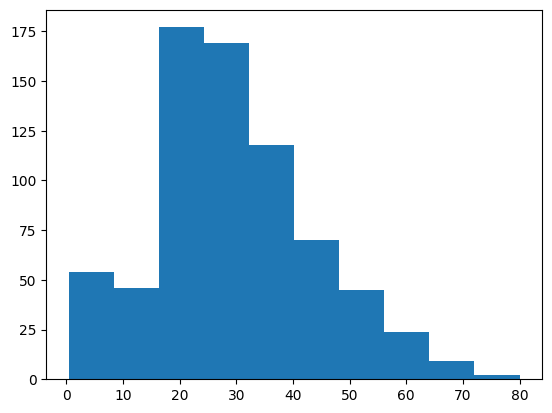

In [4]:
#Idade possui uma quantidade relativamente baixa de valores faltantes(177), significa que é melhor manter essa col
#Preencheremos os valores faltantes de idade com a média

fig, axs = plt.subplots()
axs.hist(dttr['Age'])

print("Media: ", dttr['Age'].mean(), " Mediana: ",  dttr['Age'].median()," Moda: ", (dttr["Age"]).mode()[0])

AgMdn = dttr['Age'].median() # Podemos usar média, mediana ou moda para preencher, a média é mais comum
# A mediana é recomendada para distribuições com outliers, que podem puxar a média para cima
# Acredito que as duas são válidas, mas como temos uma dist. um pouco assimétrica, usarei a mediana

dttrCopy = dttr.copy()

dttrCopy['Age'] = dttr['Age'].fillna(AgMdn)

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


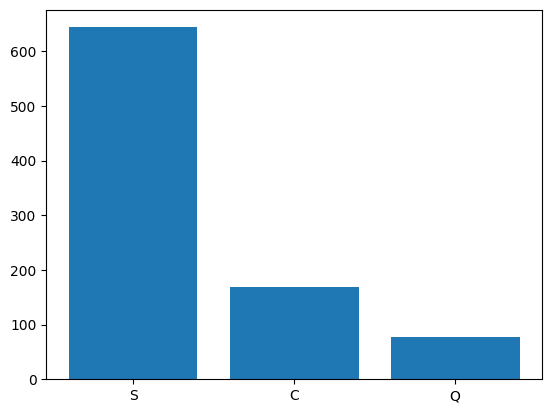

In [5]:
# Por embarked ser um valor categórico, devemos utilizar a moda como valor de imputação nos nulos
print(dttr['Embarked'].value_counts())

fig, axs = plt.subplots()
axs.bar(dttr['Embarked'].value_counts().index, dttr['Embarked'].value_counts())

dttrCopy['Embarked'] = dttr['Embarked'].fillna("S")

In [6]:
# Por último temos Cabin, como essa variável é em grande parte composta por faltantes
# Creio que a melhor opção seja removê-la do DataSet

dttrCopy = dttrCopy.drop("Cabin", axis = 1)
dttrCopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


### Transformando variáveis categóricas
Após tratados os valores faltantes, devemos levar em consideração as variáveis categóricas que devem ser convertidas para numéricas utilizando as técnicas recomendadas.

Antes de converter tudo, primeiro vou retirar alguns atributos que não será verdadeiramente úteis no aprendizado do modelo, sendo esses atributos que são utilizados apenas para identificação dos indivíduos:

    - Name - O nome das pessoas não tem nenhuma relação com o resultado e não tem nenhuma utilidade verdadeira.
    - PassengerId - O id só serve para identificá-los e, assim como o nome, não possui utilidade para o modelo.

Outro atributo que pode resolvi olhar para ele foi o "Ticket", boa parte(547 de 891) dos Tickets são únicos, o que pode levar a considerar esse atributo como não suficientemente informativo, levarei ele em consideração a primeiro ponto, checar se ele vai realmente ser informativo em algum nível.

In [7]:
dttrCopy = dttrCopy.drop(["Name", "PassengerId"], axis = 1)

dttrCopy['Ticket'].value_counts().value_counts() # Código para enxergar quantos Tickets únicos há no DS.
dttrCopy = dttrCopy.drop(["Ticket"], axis = 1)
# Mantendo o Ticket temos um dataset com mais de 600 colunas, por conta do OneHot, por se tratar de uma coluna
# que agrega pouca informação resolvi retirá-la

In [8]:
# Agora vamos para a codificação de Variáveis Categóricas para Numéricas

catAttr = dttrCopy.select_dtypes(include = ['object']).columns # recebendo o nome de todas as colunas categóricas
numAttr = dttrCopy.select_dtypes(exclude = ['object']).columns # pegando todas as colunas numéricas, utilizaremos depois

print(numAttr)

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


Ao final, possuímos 3 variáveis categóricas -> "Sex", "Ticket" e "Embarked".

Tratam-se de 3 variáveis categóricas nominais, logo não possuem nenhuma *ordem* entre as classificações, o que significa que devemos utilizar o One Hot Encoder na codificação dessas variáveis. 

In [9]:
from sklearn.preprocessing import OneHotEncoder

OHencoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False, categories = "auto", dtype='int8')

codColumns = pd.DataFrame(OHencoder.fit_transform(dttrCopy[catAttr]))
columns = OHencoder.get_feature_names_out(catAttr)
codColumns.columns = columns

codColumns.index = dttrCopy.index # Igualando os indices

dttrCopy = dttrCopy.drop(catAttr, axis = 1) # Excluindo as colunas que vamos substituir pelos OneHot's

dttrCopy = pd.concat([dttrCopy, codColumns], axis = 1)

print(dttrCopy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_female  891 non-null    int8   
 7   Sex_male    891 non-null    int8   
 8   Embarked_C  891 non-null    int8   
 9   Embarked_Q  891 non-null    int8   
 10  Embarked_S  891 non-null    int8   
dtypes: float64(2), int64(4), int8(5)
memory usage: 46.2 KB
None


### Analisando as Escalas
As Escalas de cada um dos dados podem ser altamente nocivas para o KNN, dependendo de suas escalas, pois sem uma padronização das escalas haverá valores "dominantes", que vão dominar o cálculo da distância, puxando a classificação sempre para si.

Logo, é necessário utilizar algum tipo de *normalização* da escala dos dados. A diferença das Escalas podem ser observadas quando utilizamos o describe e observamos as médias, os quartis e outras estatísticas que nos trazem ideia da escala da coluna.

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


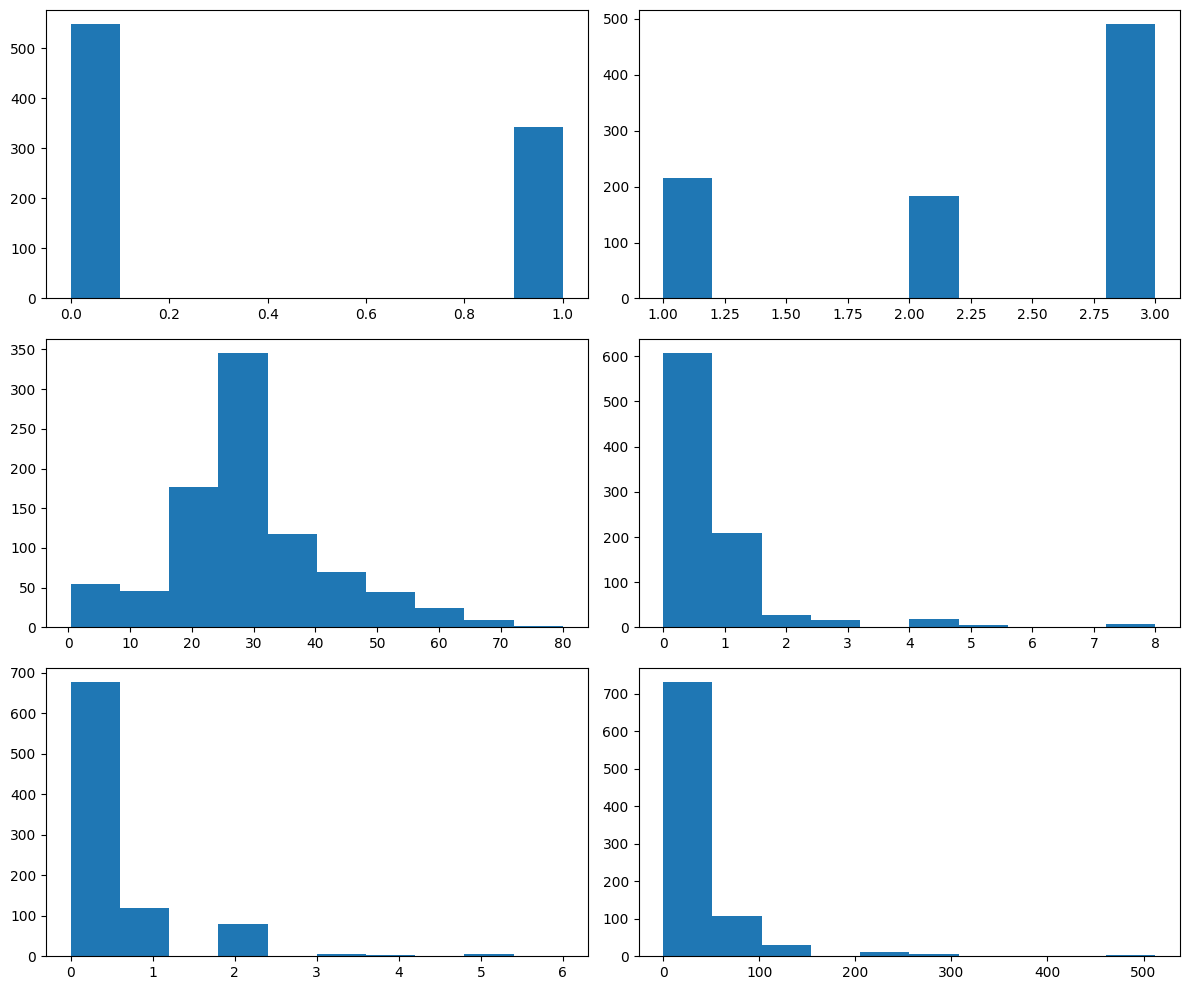

In [10]:
dtTemp = dttrCopy[numAttr]
fig, axs = plt.subplots(3, 2, figsize = (12, 10))

print(numAttr)

# Para ter uma ideia sobre a distribuição das Variáveis Numéricas Originais que temos,resolvi plotar para enxergá-las
for i, ax in enumerate(axs.flatten()):
    ax.hist(dtTemp.iloc[:, i])

plt.tight_layout()
plt.show()

Devido a presença de Alguns Outliers, o MinMaxScaler pode seur prejudicado, dessa forma, utilizarei o StandardScaler para a mudança de escala dos dados. 

In [11]:
from sklearn.preprocessing import StandardScaler

numAttr = numAttr[1:] # Retirando o Survived(Y) da mudança de Escala pois ele é Bool

stdS = StandardScaler()
stdS.fit(dttrCopy[numAttr])
dttrCopy[numAttr] = stdS.transform(dttrCopy[numAttr])

## Cálculo da Correlação dos Atributos com o Y
Uma das Formas de enxergar a relação entre variáveis numéricas é através do cálculo da Matriz de correlação. Valores com maior valor do correlação absoluto com a variável *Survived* possuem uma boa chance de trazerem uma boa quantidade de informação, melhorando o aprendizado do modelo.

Survived      1.000000
Sex_female    0.543351
Fare          0.257307
Embarked_C    0.168240
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.064910
Embarked_S   -0.149683
Pclass       -0.338481
Sex_male     -0.543351
Name: Survived, dtype: float64


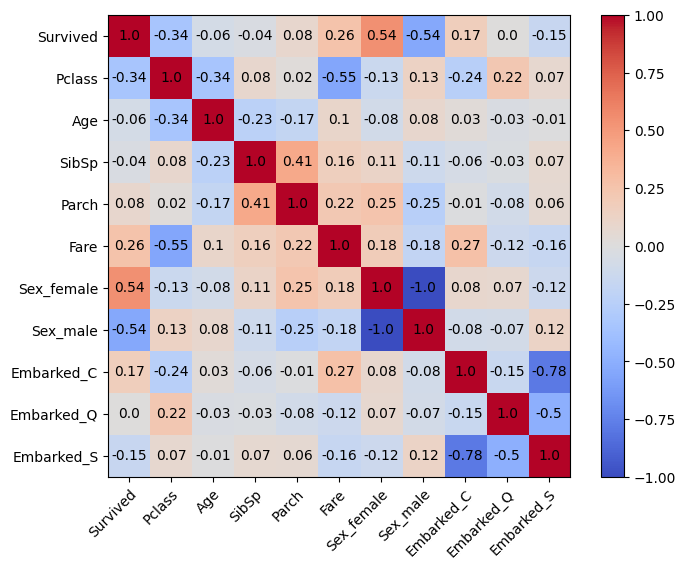

In [12]:
# Calcula a matriz de correlação entre as colunas
corrMtx = dttrCopy.corr()

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corrMtx, cmap='coolwarm')

for i in range(len(corrMtx.columns)):
    for j in range(len(corrMtx.columns)):
        text = ax.text(j, i, round(corrMtx.iloc[i, j], 2),
                       ha='center', va='center', color='black')


cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(range(len(corrMtx.columns)))
ax.set_xticklabels(corrMtx.columns)
ax.set_yticks(range(len(corrMtx.columns)))
ax.set_yticklabels(corrMtx.columns)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
print(corrMtx.loc["Survived"].sort_values(ascending = False))

Analisando os valores de correlação, podemos ver que *Survived* temos valores de correlações relativamente altos com a variável *Sex*, além de trazer correlações relativamente boas com *PClass* e *Fare*, lembrando que estou falando do valor em módulo, já que altas correlações negativas podem trazer tantas informações quanto altas correlações positivas.

Além disso, temos baixissimas correlações com as variáveis *Age, Parch* e *SibSp*, o que leva a crer que não trazem muita informação por isso não serão levadas em consideração.

Também temos baixa correlações com as variáveis de *Embarked* no entando preferi mantê-las já que já temos uma quantidade relativamente baixa de colunas e por se tratarem de uma variável categórica transformada em numérica a correlação pode não ser tão significativa assim.

In [13]:
dttrCopy = dttrCopy.drop(["Age", "Parch", "SibSp"], axis = 1)

dttrCopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    float64
 2   Fare        891 non-null    float64
 3   Sex_female  891 non-null    int8   
 4   Sex_male    891 non-null    int8   
 5   Embarked_C  891 non-null    int8   
 6   Embarked_Q  891 non-null    int8   
 7   Embarked_S  891 non-null    int8   
dtypes: float64(2), int64(1), int8(5)
memory usage: 25.4 KB


Isso nos leva a ter apenas 3 variáveis, *Sex, Pclass e Fare*.

## Preparo para o modelo

Agora vamos para a parte da divisão dos dados, vamos dividir em:

75% Treino = 668,25

25% Teste = 222.75

10% do treino Validação = 66,825

As Proporções de divisão serão essas.

Após fazer todos os pré-processamentos que fiz no treino no teste, agora vamos criar o teste e validação, lembrando que estou fazendo isso aleatoriamente, mas manterei a *random seed* fixa para não depender da aleatoriedade do resultado para definir o K, pois sem isso teria que fazer uma análise mais complicada.

In [14]:
indices = np.random.RandomState(seed=0).permutation((dttrCopy).index)
    
#dividindo em treino e teste
indxTrn = indices[:int(len(dttrCopy)*0.75)]
indxTst =  indices[int(len(dttrCopy)*0.75):]

dttrn = dttrCopy.loc[indxTrn, :]
dttst = dttrCopy.loc[indxTst, :]

xtrn = dttrn.drop("Survived", axis = 1).reset_index(drop = True)
ytrn = dttrn["Survived"].reset_index(drop = True)

xtst = dttst.drop("Survived", axis = 1).reset_index(drop = True)
ytst = dttst["Survived"].reset_index(drop = True)

Após essa subdivisão dos dados que temos, vamos fazer as predições necessárias para selecionar os melhores K's.

In [15]:
from sklearn.metrics import accuracy_score
import pandas as pd

k = 10
acuracias = pd.DataFrame(columns=['k', 'acuracia'])
indice = 0

# Dividindo os dados em k partes iguais
x_folds = np.array_split(xtrn, k)
y_folds = np.array_split(ytrn, k)

for i in range(3, 123, 4):
    acuracia_media = 0
    
    for j in range(k):
        # Separando em dado treino e validação, capturando 10% do dano de treino
        x_train = pd.concat(x_folds[:j] + x_folds[j+1:]).reset_index(drop = True)
        y_train = pd.concat(y_folds[:j] + y_folds[j+1:]).reset_index(drop = True)
        x_valid = x_folds[j].reset_index(drop = True)
        y_valid = y_folds[j].reset_index(drop = True)
        
        knn = KNN(i)
        knn.saveXY(x_train, y_train)
        
        # Fazendo a classificação
        predictions = pd.Series(index=x_valid.index)
        for idx, datapoint in x_valid.iterrows():
            prediction = knn.classify(datapoint)
            predictions[idx] = prediction
        
        # Calculando a acurácia dessa rodada
        acuracia = accuracy_score(y_valid, predictions)
        acuracia_media += acuracia
    
    acuracia_media /= k
    acuracias.loc[indice] = [i, acuracia_media]
    indice += 1

print(acuracias)

# Imprimindo o melhor valor de K de acordo com a acurácia média
melhor_k = acuracias.loc[acuracias['acuracia'].idxmax()]['k']
print("Melhor valor de K:", melhor_k)


        k  acuracia
0     3.0  0.790525
1     7.0  0.782972
2    11.0  0.799412
3    15.0  0.803867
4    19.0  0.800837
5    23.0  0.802329
6    27.0  0.802329
7    31.0  0.800837
8    35.0  0.796336
9    39.0  0.793351
10   43.0  0.788874
11   47.0  0.791859
12   51.0  0.791882
13   55.0  0.794844
14   59.0  0.796336
15   63.0  0.794844
16   67.0  0.791882
17   71.0  0.794844
18   75.0  0.799344
19   79.0  0.787404
20   83.0  0.785911
21   87.0  0.763569
22   91.0  0.766554
23   95.0  0.765038
24   99.0  0.765038
25  103.0  0.765038
26  107.0  0.765038
27  111.0  0.763546
28  115.0  0.760516
29  119.0  0.763501
Melhor valor de K: 15.0


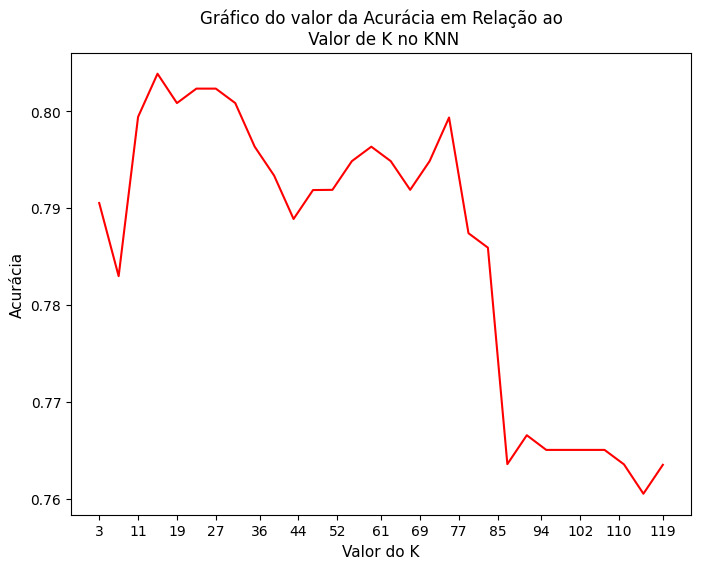

In [16]:
fig, ax = plt.subplots(figsize = (8, 6))
x = acuracias["k"]
y = acuracias["acuracia"]

ax.plot(x, y, 'r-')
ax.set_title("Gráfico do valor da Acurácia em Relação ao\n Valor de K no KNN")
ax.set_xlabel("Valor do K", fontsize = 11)
ax.set_ylabel("Acurácia", fontsize = 11)
ax.set_xticks((np.linspace(3, 119, 15)).astype(int)) 
# setei apenas de 8 em 8 pois de 4 em 4 dificultava a visualização
print()

Após a análise vinda dos dados da Validação Cruzada e do teste do Valor do K, o melhor K é o valor 15, dessa forma, agora iremos retreinar um KNN de K = 15, com os dados de treino e validação juntos, após isso iremos calcular a acurácia do teste.

In [17]:
from sklearn.metrics import confusion_matrix

knn = KNN(15)
knn.saveXY(xtrn, ytrn) # retreinamos o modelo
predictions = np.zeros(len(xtst))
for idx, datapoint in xtst.iterrows(): # For que calcula a classificação de cada modelo
    prediction = knn.classify(datapoint)
    predictions[idx] = prediction
    
cfsM =confusion_matrix(ytst, predictions)
acuracia = accuracy_score(ytst, predictions)
print("Acurácia do teste para K = 15: ", acuracia)

Acurácia do teste para K = 15:  0.7892376681614349


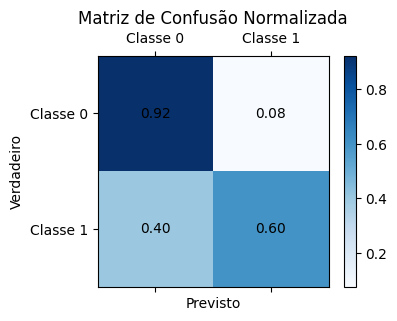

In [18]:
# Normalize a matriz de confusão
confusion_norm = cfsM.astype('float') / cfsM.sum(axis=1)[:, np.newaxis]

# Crie uma figura
fig, ax = plt.subplots(figsize=(4, 3))

# Plote a matriz de confusão normalizada
im = ax.matshow(confusion_norm, cmap='Blues')

# Adicione a barra de cores
fig.colorbar(im)

# Adicione as etiquetas dos eixos
ax.set_xlabel('Previsto')
ax.set_ylabel('Verdadeiro')

# Adicione as etiquetas das classes
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Classe 0', 'Classe 1'])
ax.set_yticklabels(['Classe 0', 'Classe 1'])

# Adicione os valores dentro das células
for i in range(confusion_norm.shape[0]):
    for j in range(confusion_norm.shape[1]):
        ax.text(j, i, '{:.2f}'.format(confusion_norm[i, j]), ha='center', va='center', color='black')

# Adicione o título
ax.set_title('Matriz de Confusão Normalizada')

# Mostre o gráfico
plt.show()

### Resultados

Basicamente esses são os resultados do Modelo, a acurácia fica ali em torno de 0.79, de forma que a maioria dos erros acontecem na classe de predição 1.

Essa foi a implementação de KNN utilizando o DataSet Titanic, tentei fazer todas as análises requisitadas na atividade.

Um ponto de análise que tive certa dificuldade foi com o *Embarked*, primeiro retirei ele e testei o modelo várias vezes e depois vi os resultados com ele levado em consideração. A diferença nos resultados foi basicamente que, mantendo o *Embarked*, o KNN precisa de um K menor para checar na média de erro de 0.79.